# Machine Learning 1 - Classification project

Classification in machine learning is a common problem of putting data instances into groups (binary, multi-class or multi-label) based on their characteristics. It can be used in many real world business problem like credit risk, fraud detection, disease prediction. Based on historical data and given 'target' variable, classifiers find patterns and are able to adapt those patterns to new data. The main goal of classification in machine is to obtain the most accurate prediction as possible. The accuracy can be measured with a couple of metrics like ROC-AUC curve, F1 score, Confusion Matrix et. al. As a metric for this project I will use the <b>balanced accuracy</b>.<br>
The main task of this project is to apply various ML algorithms to build a model explaining whether a particular person consumed cocaine in the last month based on the training sample and generate predictions for all observations from the test sample.

# Import libraries

Let's begin with importing all necessary libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve, auc, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline

import collections
from collections import Counter

from imblearn.pipeline import make_pipeline as make_pipeline
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.metrics import classification_report_imbalanced
import warnings
warnings.filterwarnings("ignore")

# Data preparation

Import training dataset csv file

In [182]:
df = pd.read_csv("data/drugs_train.csv")
df.head()

,id,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,...,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine,consumption_cocaine_last_month
0,train_0001,45-54,male,Masters degree,USA,Mixed-Black/Asian,57.6,57.3,50.1,47.8,...,42.8,22.4,used in last week,used over a decade ago,used in last day,used in last week,used in last day,never used,used in last week,No
1,train_0002,25-34,male,University degree,USA,Mixed-Black/Asian,47.8,67.0,45.7,47.8,...,33.8,30.8,used in last week,never used,used in last week,never used,used in last day,never used,never used,No
2,train_0003,18-24,female,University degree,USA,Mixed-Black/Asian,57.6,43.3,55.3,45.6,...,63.0,62.0,used in last month,never used,used in last day,used in last week,used in last week,used in last year,used in last month,No
3,train_0004,25-34,female,Masters degree,USA,Mixed-Black/Asian,71.8,31.2,43.6,56.3,...,63.0,71.1,used in last day,never used,used in last day,used in last decade,used in last day,never used,used in last decade,No
4,train_0005,18-24,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,56.1,62.3,70.2,66.1,...,50.4,62.0,used in last week,never used,used in last month,used in last month,used in last day,used in last year,used in last month,No


The training dataset contaings of 21 variables and 1500 observations. 

I am removing the id variable. This variable is unique for each row and does not add any information. I map the value of the dependent variable from Yes to 1 and from No to 0.

In [183]:
df.drop(columns=['id'], inplace = True)

df['consumption_cocaine_last_month'] = df['consumption_cocaine_last_month'].map({'Yes': 1, 'No': 0})

I check basic descriptive statistics to find outliers. I don't see anything alarming in the data that would indicate the existence of outliers.

In [184]:
df.describe()

,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_cocaine_last_month
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,51.507267,50.053667,53.108667,49.966000,49.998800,46.972200,52.316333,0.084667
std,14.958815,15.200954,16.049880,14.340301,14.571548,17.361892,23.686221,0.278478
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,41.300000,39.400000,41.400000,41.200000,40.600000,33.800000,38.800000,0.000000
50%,52.000000,50.100000,52.700000,49.800000,49.900000,42.800000,54.000000,0.000000
75%,60.800000,59.700000,64.700000,58.500000,58.400000,56.500000,71.100000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000


Let's see what variables are in our dataset

In [185]:
df.columns

Index(['age', 'gender', 'education', 'country', 'ethnicity',
       'personality_neuroticism', 'personality_extraversion',
       'personality_openness', 'personality_agreeableness',
       'personality_conscientiousness', 'personality_impulsiveness',
       'personality_sensation', 'consumption_alcohol',
       'consumption_amphetamines', 'consumption_caffeine',
       'consumption_cannabis', 'consumption_chocolate',
       'consumption_mushrooms', 'consumption_nicotine',
       'consumption_cocaine_last_month'],
      dtype='object')

Let's look at the explained variable. Let's see what the distribution of 1 and 0 is. 

In [186]:
print('No', round(df['consumption_cocaine_last_month'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Yes', round(df['consumption_cocaine_last_month'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No 91.53 % of the dataset
Yes 8.47 % of the dataset


I see that only 8 per cent of observations are positive. So I have a problem with unbalanced data. It will be necessary to find a way to deal with this problem. Let's see it in the graph.

<AxesSubplot:xlabel='consumption_cocaine_last_month', ylabel='count'>

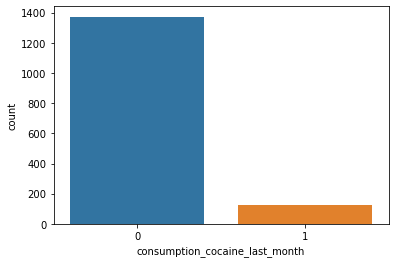

In [187]:
sns.countplot('consumption_cocaine_last_month', data=df)

The gender variable is balanced and does not need to be modified.

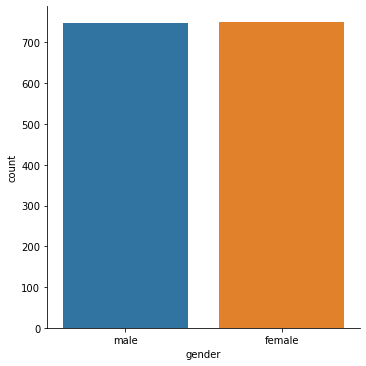

In [188]:
sns.catplot(x='gender', kind="count", data=df)

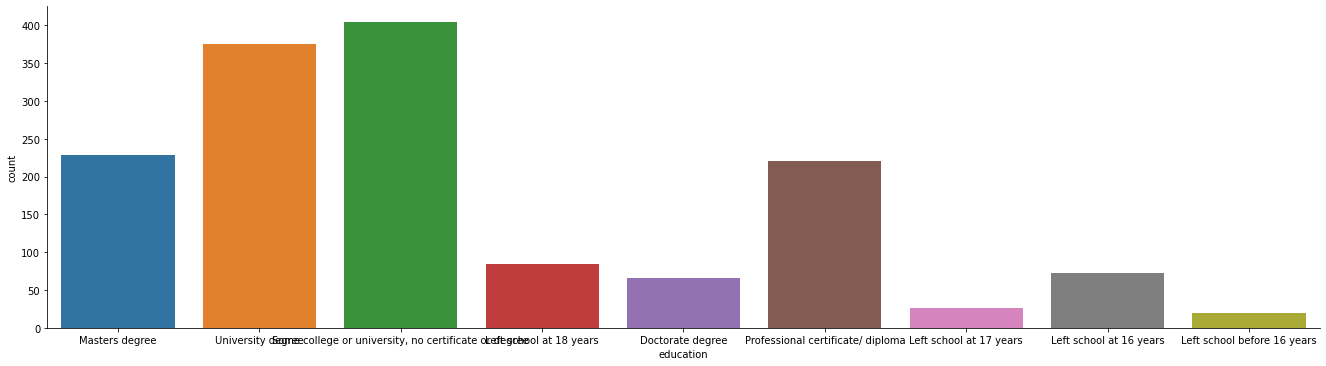

In [189]:
sns.catplot(x='education', kind="count", data=df)

The `education` variable has some small-volume levels. I combine the three least frequent levels into one `Left school before 18 years`.

In [190]:
df.loc[df["education"] == "Left school at 17 years", "education"] = "Left school before 18 years"
df.loc[df["education"] == "Left school at 16 years", "education"] = "Left school before 18 years"
df.loc[df["education"] == "Left school before 16 years", "education"] = "Left school before 18 years"

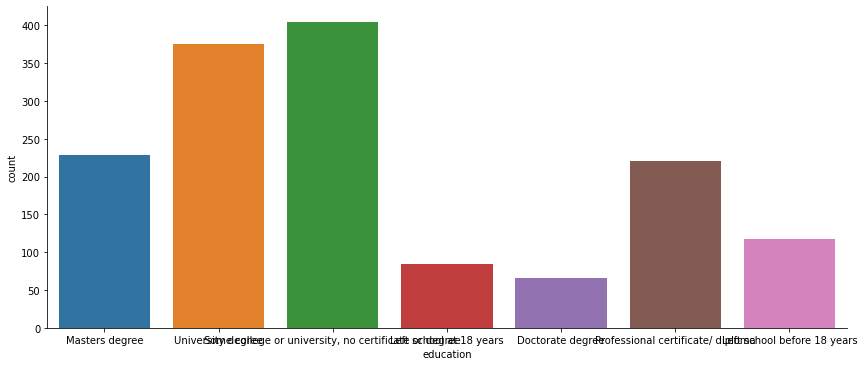

In [191]:
sns.catplot(x='education', kind="count", data=df)

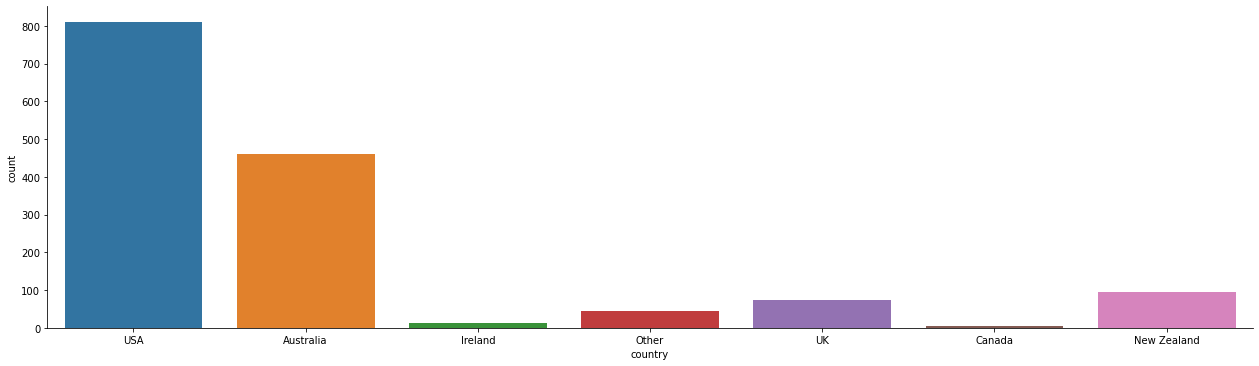

In [192]:
sns.catplot(x='country', kind="count", data=df)

The `country` variable, as before, has few levels. I link it to `Other country`.

In [193]:
df.loc[df["country"] == "Canada", "country"] = "Other country"
df.loc[df["country"] == "Ireland", "country"] = "Other country"

In the following variables (`ethnicity`, `consumption_alcohol`, `consumption_chocolate`, `consumption_mushrooms`, `consumption_nicotine`), I also observe low levels. In each case I proceed in the same way. By combining them into larger levels.

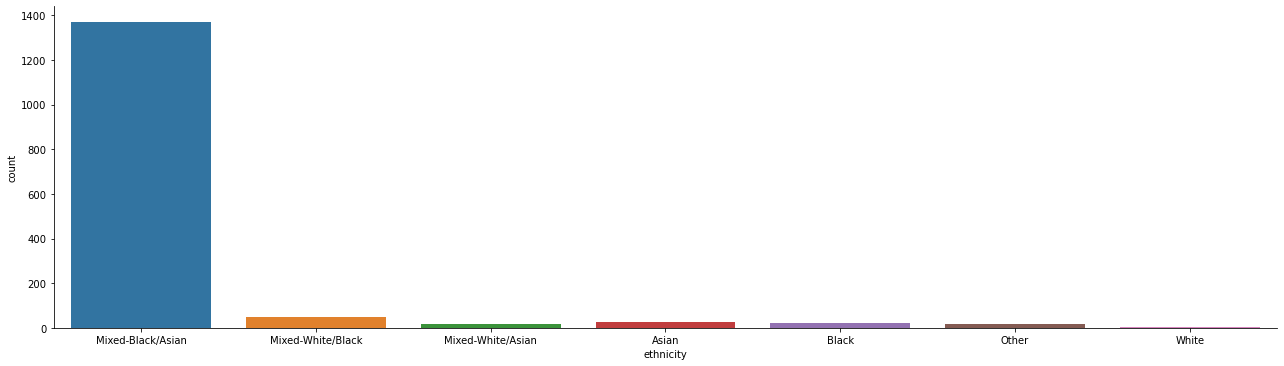

In [194]:
sns.catplot(x='ethnicity', kind="count", data=df)

In [195]:
df.loc[df["ethnicity"] == "Asian", "ethnicity"] = "Other"
df.loc[df["ethnicity"] == "Black", "ethnicity"] = "Other"
df.loc[df["ethnicity"] == "Other", "ethnicity"] = "Other"
df.loc[df["ethnicity"] == "White", "ethnicity"] = "Other"
df.loc[df["ethnicity"] == "Mixed-White/Asian", "ethnicity"] = "Other"
df.loc[df["ethnicity"] == "Mixed-White/Black", "ethnicity"] = "Other"

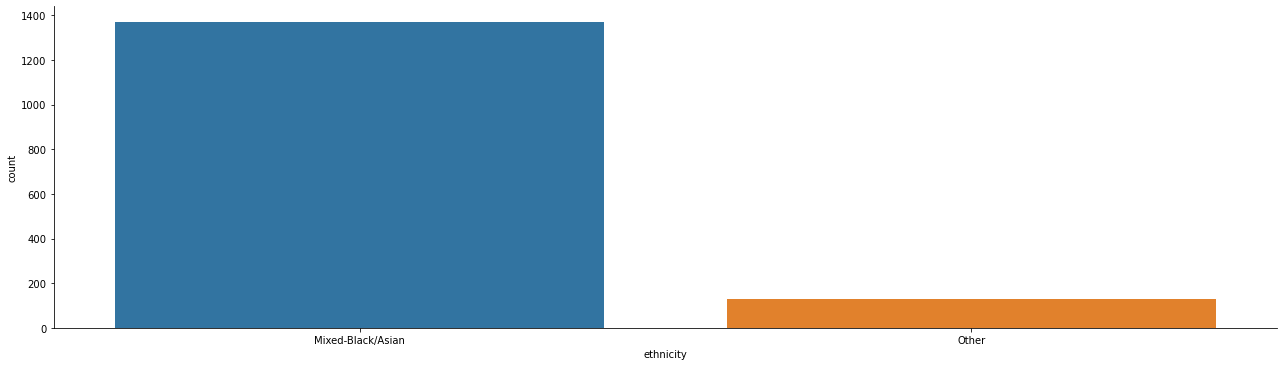

In [196]:
sns.catplot(x='ethnicity', kind="count", data=df)

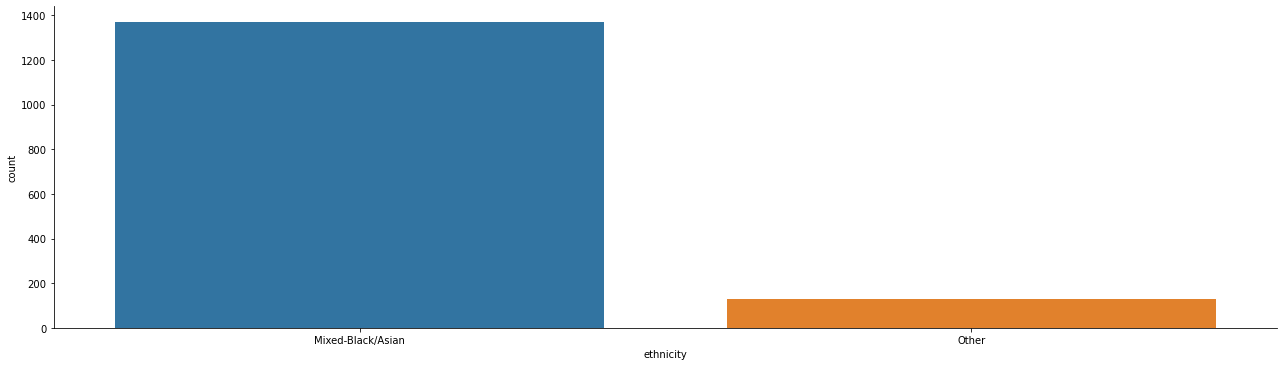

In [197]:
sns.catplot(x='ethnicity', kind="count", data=df)

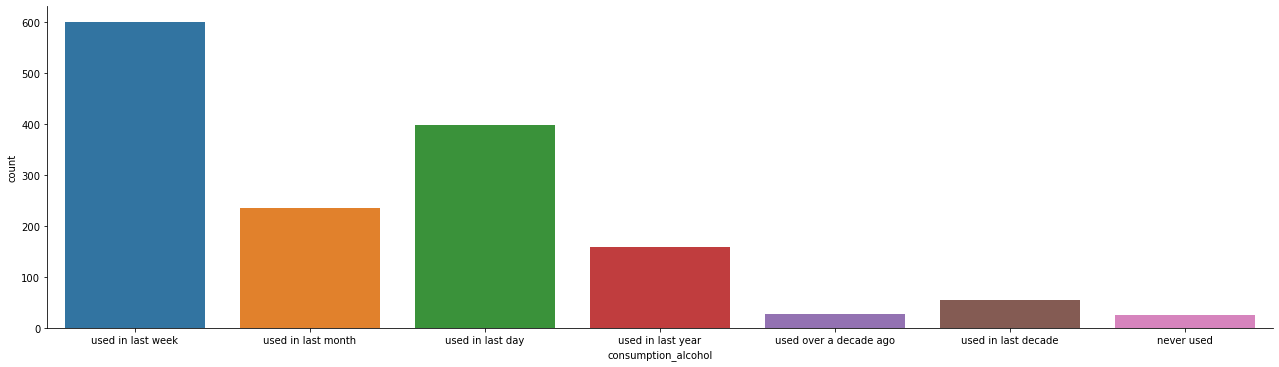

In [198]:
sns.catplot(x='consumption_alcohol', kind="count", data=df)

In [199]:
df.loc[df["consumption_alcohol"] == "never used", "consumption_alcohol"] = "more than year ago"
df.loc[df["consumption_alcohol"] == "used in last decade", "consumption_alcohol"] = "more than year ago"
df.loc[df["consumption_alcohol"] == "used over a decade ago", "consumption_alcohol"] = "more than year ago"

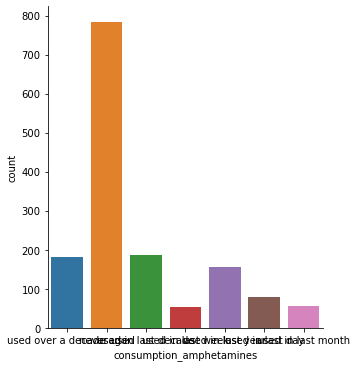

In [200]:
sns.catplot(x='consumption_amphetamines', kind="count", data=df)

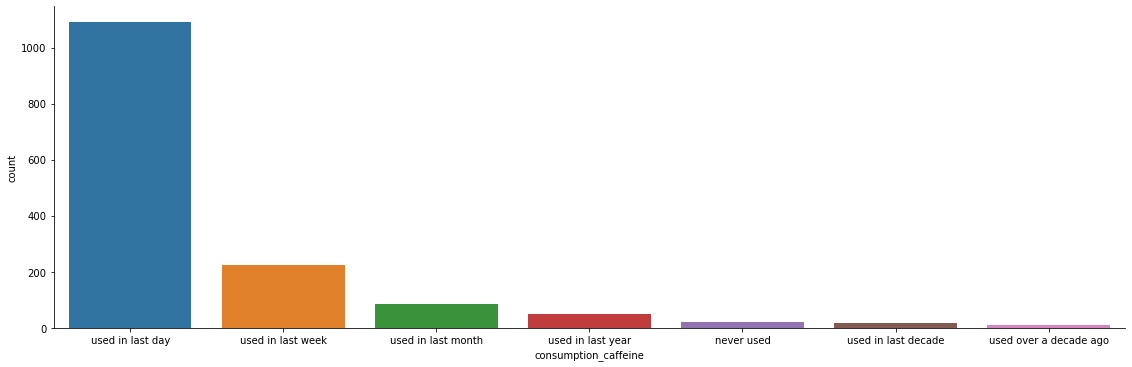

In [201]:
sns.catplot(x='consumption_caffeine', kind="count", data=df)

In [202]:
df.loc[df["consumption_caffeine"] == "used in last decade", "consumption_caffeine"] = "more than month ago"
df.loc[df["consumption_caffeine"] == "used over a decade ago", "consumption_caffeine"] = "more than month ago"
df.loc[df["consumption_caffeine"] == "used in last year", "consumption_caffeine"] = "more than month ago"
df.loc[df["consumption_caffeine"] == "never used", "consumption_caffeine"] = "more than month ago"

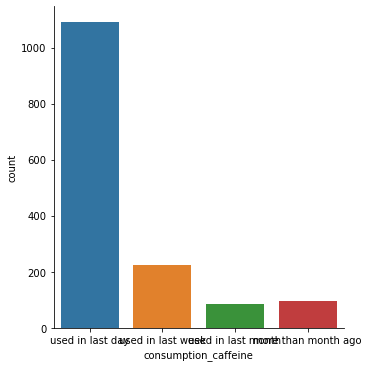

In [203]:
sns.catplot(x='consumption_caffeine', kind="count", data=df)

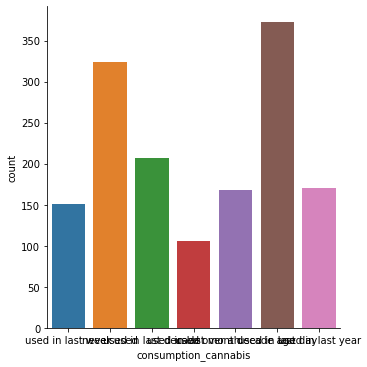

In [204]:
sns.catplot(x='consumption_cannabis', kind="count", data=df)

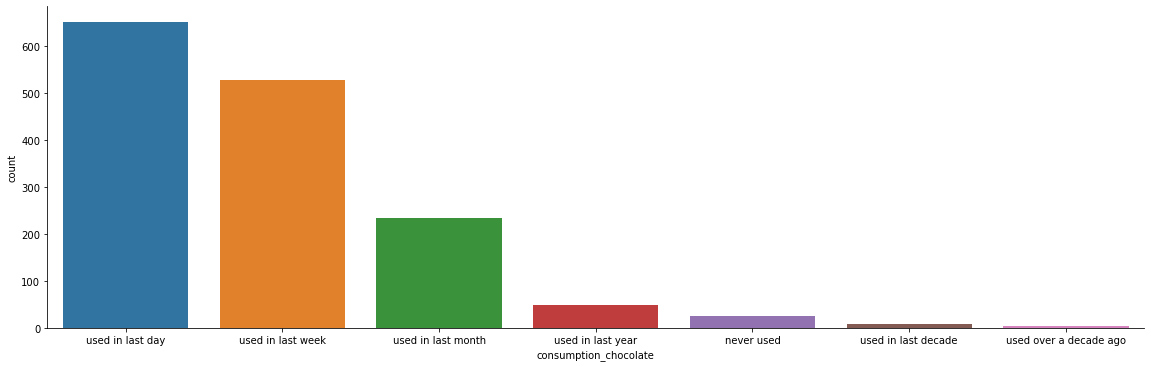

In [205]:
sns.catplot(x='consumption_chocolate', kind="count", data=df).fig.set_figwidth(20)

In [206]:
df.loc[df["consumption_chocolate"] == "used in last decade", "consumption_chocolate"] = "more than month ago"
df.loc[df["consumption_chocolate"] == "used over a decade ago", "consumption_chocolate"] = "more than month ago"
df.loc[df["consumption_chocolate"] == "never used", "consumption_chocolate"] = "more than month ago"
df.loc[df["consumption_chocolate"] == "used in last year", "consumption_chocolate"] = "more than month ago"

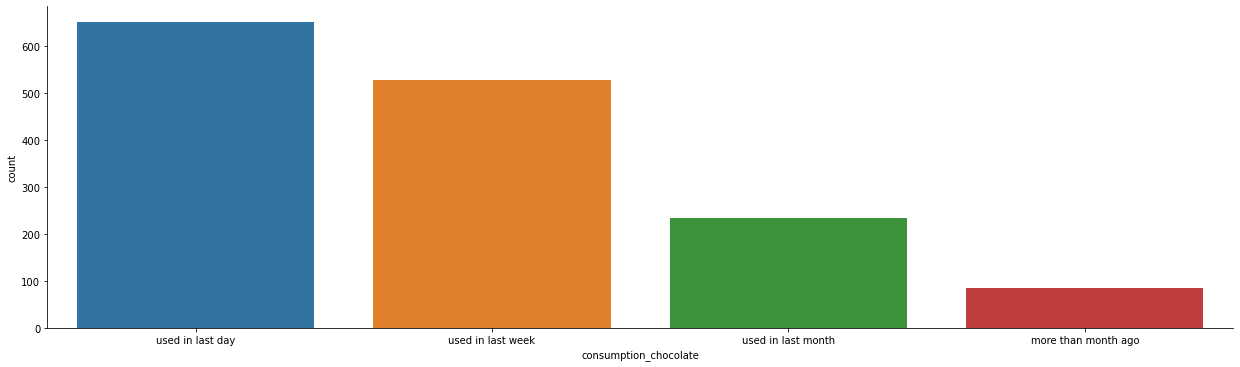

In [207]:
sns.catplot(x='consumption_chocolate', kind="count", data=df)

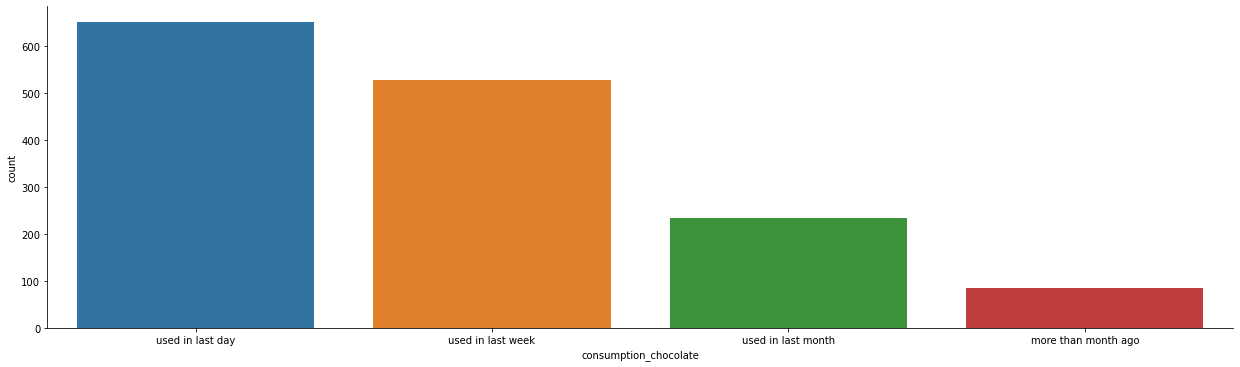

In [208]:
sns.catplot(x='consumption_chocolate', kind="count", data=df)

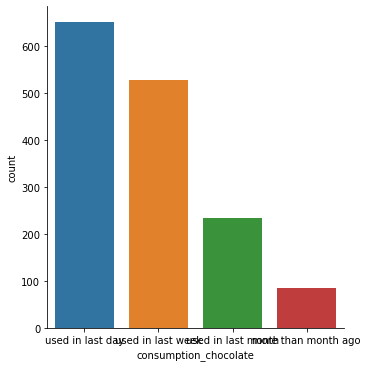

In [209]:
sns.catplot(x='consumption_chocolate', kind="count", data=df)

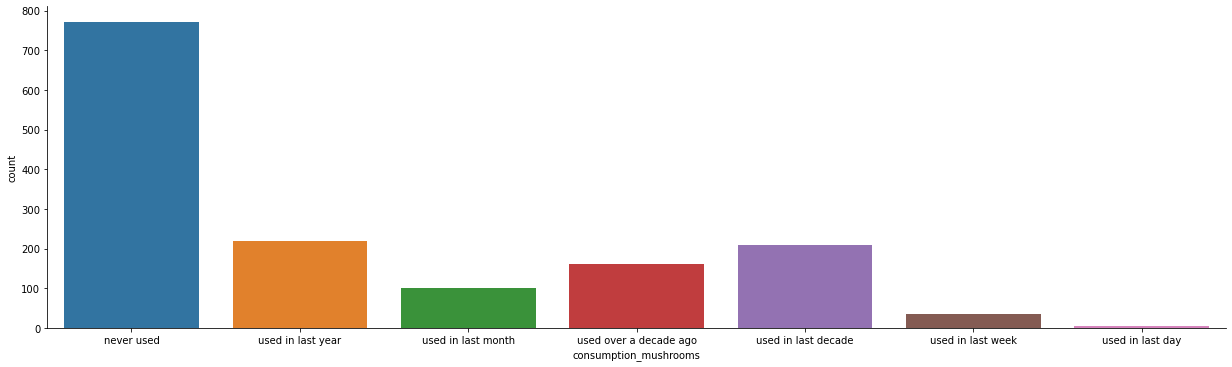

In [210]:
sns.catplot(x='consumption_mushrooms', kind="count", data=df)

In [211]:
df.loc[df["consumption_mushrooms"] == "used in last week", "consumption_mushrooms"] = "used recently"
df.loc[df["consumption_mushrooms"] == "used in last day", "consumption_mushrooms"] = "used recently"

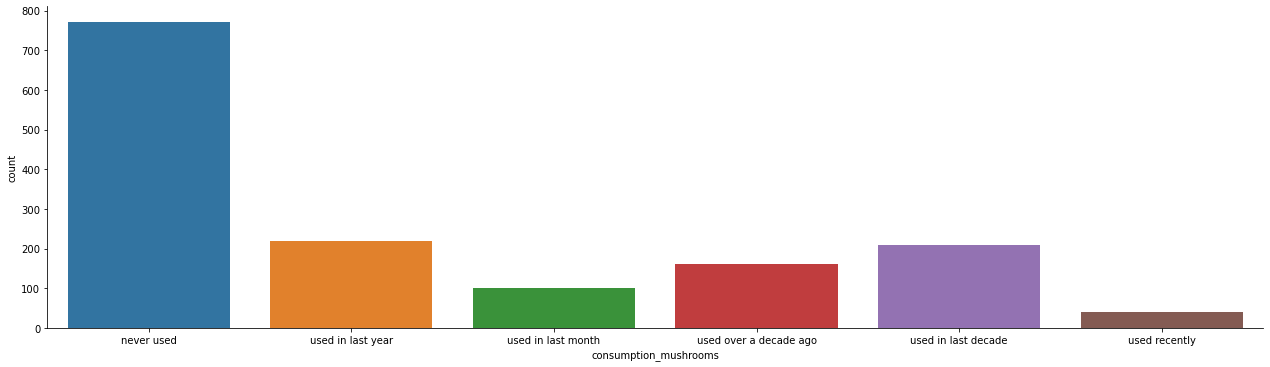

In [212]:
sns.catplot(x='consumption_mushrooms', kind="count", data=df)

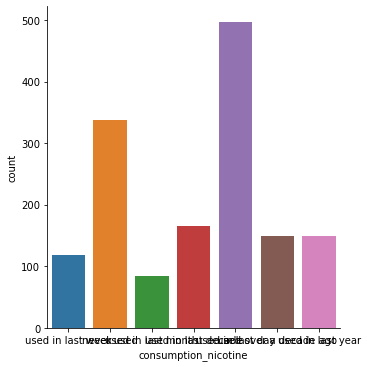

In [213]:
sns.catplot(x='consumption_nicotine', kind="count", data=df)

I convert categorical variables to dummies.

In [214]:
df = pd.get_dummies(df, columns = ['age', 'gender', 'education', 'country', 'ethnicity','consumption_alcohol',
       'consumption_amphetamines', 'consumption_caffeine',
       'consumption_cannabis', 'consumption_chocolate',
       'consumption_mushrooms', 'consumption_nicotine'])

For easier analysis, I divide all levels of numerical variables by 100 (all were previously scaled from 0 to 100).

In [215]:
df['personality_neuroticism'] = df['personality_neuroticism']/100
df['personality_extraversion'] = df['personality_extraversion']/100
df['personality_openness'] = df['personality_openness'] / 100
df['personality_agreeableness'] = df['personality_agreeableness']/100
df['personality_conscientiousness'] = df['personality_conscientiousness']/100
df['personality_impulsiveness'] = df['personality_impulsiveness']/100
df['personality_sensation'] = df['personality_sensation'] /100
#df['consumption_alcohol'] = df['consumption_alcohol']/100
#df['consumption_amphetamines'] = df['consumption_amphetamines']/100
#df['consumption_caffeine'] = df['consumption_caffeine']/100
#df['consumption_cannabis'] = df['consumption_cannabis']/100
#df['consumption_chocolate'] = df['consumption_chocolate']/100
#df['consumption_mushrooms'] = df['consumption_mushrooms']/100
#df['consumption_nicotine'] = df['consumption_nicotine']/100
#df['consumption_cocaine_last_month'] =df['consumption_cocaine_last_month']/100

I check what variables I have after all the modifications.

In [216]:
df.columns

Index(['personality_neuroticism', 'personality_extraversion',
       'personality_openness', 'personality_agreeableness',
       'personality_conscientiousness', 'personality_impulsiveness',
       'personality_sensation', 'consumption_cocaine_last_month', 'age_18-24',
       'age_25-34', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65+',
       'gender_female', 'gender_male', 'education_Doctorate degree',
       'education_Left school at 18 years',
       'education_Left school before 18 years', 'education_Masters degree',
       'education_Professional certificate/ diploma',
       'education_Some college or university, no certificate or degree',
       'education_University degree', 'country_Australia',
       'country_New Zealand', 'country_Other', 'country_Other country',
       'country_UK', 'country_USA', 'ethnicity_Mixed-Black/Asian',
       'ethnicity_Other', 'consumption_alcohol_more than year ago',
       'consumption_alcohol_used in last day',
       'consumption_alcohol_use

I write the list of explanatory variables as `features` and the variable `consumption_cocaine_last_month` to `target`.

In [217]:
features = df.columns
target = 'consumption_cocaine_last_month'

Oversampling is the synthetic creation of new data. Therefore, if I want to measure the actual performance of the models later, it is important to save the original values on which I will not make any modifications.

In [218]:
X = df.drop('consumption_cocaine_last_month', axis=1)
y = df['consumption_cocaine_last_month']

sKFold = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sKFold.split(X, y):
    orgXtrain, orgXtest = X.iloc[train_index], X.iloc[test_index]
    orgytrain, orgytest = y.iloc[train_index], y.iloc[test_index]

orgXtrain = orgXtrain.values
orgXtest = orgXtest.values
orgytrain = orgytrain.values
orgytest = orgytest.values

I also do a custom train split test creating data that will feed into the estimated models.

In [219]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Oversampling - SMOTE + Tomek

As I mentioned earlier, the data are unbalanced. One way to deal with this problem is SMOTE oversampling (another way is undersampling, but I'm not dealing with it in this project). Synthetic Minority Oversampling TEchnique (SMOTE) works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line. 

Additionally, I combine this technique with undersampling Tomek. Undersampling Tomek is not yet explored. However, it is believed that combining these two techniques will reduce recall (at the expense of precision). Reducing recall will improve balanced accuracy, which is the main goal of this project.

This way I get a balanced dataset with synthetic data.

## Manual parameter tunning

I am testing the performance of various algorithms: Random Forrest, k-Nearest Neighbors, Logistic Regression and Support Vector Classifier. I do hyperparameter tuning manually.

### Random Forrest

In [367]:
def CVTestRFClass(nFolds = 6, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    sKFold = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in sKFold.split(X_train, y_train):
        # Prepare the estimator
        clf = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), RandomForestClassifier(*args, **kwargs, random_state=randomState)) 
        
        if debug:
            print(clf)
        # Train the model
        clf.fit(X_train[train], y_train[train])

        predsTrain = clf.predict(X_train[train])
        preds = clf.predict(X_train[test])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        #indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = balanced_accuracy_score(y_train[train], predsTrain)
        testScore = balanced_accuracy_score(y_train[test], preds)
        
        # Store Mape results to list  
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

In [368]:
trainResults, testResults, predictions, indices = CVTestRFClass()
print(np.mean(trainResults), np.mean(testResults))

1.0 0.5296737022101985


With the default settings I observe a lot of overfitting. The prediction on the training set is very large compared to the test set.

#### `min_samples_split`

In [369]:
for k in range(10, 100, 5):
    trainResults, testResults, predictions, indices = CVTestRFClass(min_samples_split=k)
    print(k, np.mean(trainResults), np.mean(testResults))

10 0.9277763768335009 0.5499975754172834
15 0.8781473257613932 0.5524576336072686
20 0.8686610845271538 0.5468074626103823
25 0.8568410146923189 0.5801175284569445
30 0.832749890903103 0.5740294012556787
35 0.8334803667152307 0.5669440049002092
40 0.8178936285922451 0.5744756520851412
45 0.8076522217697619 0.58706893471492
50 0.8058520876922266 0.599343320912664
55 0.7969798085500295 0.5947895717421265
60 0.8100656732447031 0.6093300495125312
65 0.8131815347076842 0.6057652748711143
70 0.7960388301748953 0.6123195600020418
75 0.8132637842370574 0.5982269919861161
80 0.7892123855813548 0.5882236741360829
85 0.7802272914293388 0.6128407176764841
90 0.7822433434040322 0.6318042723699658
95 0.7875188221603922 0.5961349599305804


Best result `min_samples_split` for 70.

#### `max_features`

In [375]:
for k in range(20, 30, 2):
    trainResults, testResults, predictions, indices = CVTestRFClass(min_samples_split=70, max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults))

20 0.7974199284877345 0.6001084681741616
22 0.7808856789915744 0.6147238527895462
24 0.8009026695791668 0.5945856515747027
26 0.7914826864991391 0.6319965800622735
28 0.800604444322884 0.6099894084018171


Best `max_features` score for 26.

#### `max_depth`

In [376]:
for k in range(1, 10,1):
    trainResults, testResults, predictions, indices = CVTestRFClass(min_samples_split=70, max_features=26, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults))

1 0.7345952105277914 0.7165993313256086
2 0.7686463117092684 0.7068537849012302
3 0.7840852212387786 0.7002577714256547
4 0.77381089794857 0.6722331682915624
5 0.7898875842145314 0.6676926905211578
6 0.7959577572730787 0.6448222398039916
7 0.8019870531387512 0.6500228421213823
8 0.7930613616066023 0.6386608646827625
9 0.7926593422777596 0.6382278852534327


Best for 3

#### `min_samples_leaf`

In [377]:
for k in range(1, 100,10):
    trainResults, testResults, predictions, indices = CVTestRFClass(min_samples_split=70, max_features=26, max_depth=3, min_samples_leaf=k)
    print(k, np.mean(trainResults), np.mean(testResults))

1 0.785591819813489 0.7196158950538512
11 0.7786426632592293 0.709421928436527
21 0.7725442400521357 0.7111701801847787
31 0.7914728044151462 0.7205299627379919
41 0.7742209131539795 0.708969041906998
51 0.7637756167706524 0.7071508600888163
61 0.7595779881978644 0.7037134398448267
71 0.7594517506381602 0.7033188709101118
81 0.759119365511501 0.7063000867745393
91 0.7466067361489425 0.6788775458118524


Best `min_samples_leaf` score for 31.

#### `n_estimators`

In [378]:
for k in range(100, 1000,100):
    trainResults, testResults, predictions, indices = CVTestRFClass(min_samples_split=70, max_features=26, max_depth=3, min_samples_leaf=31, n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults))

100 0.7748178588101682 0.7128560308304834
200 0.7805755323651191 0.6984979072022868
300 0.7748450026339927 0.7080665866979735
400 0.7795041569718637 0.6924672043285182
500 0.7839337065341105 0.6932489408401816
600 0.7873268016835621 0.7064324179470165
700 0.7843559457394595 0.7095393292838548
800 0.7797925317678303 0.7066847021591547
900 0.7803716889168874 0.7135078607523863


The more `n_estimators` the better.

#### Tuned model

I make a prediction on the model with the hyperparameters found.

In [434]:
best_forrest = RandomForestClassifier(min_samples_split=70, max_features=26, max_depth=3, min_samples_leaf = 31, n_estimators=1000)
pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), best_forrest) # SMOTE happens during Cross Validation not before..
model = pipeline.fit(X_train, y_train)
prediction = best_forrest.predict(orgXtrain)
print(f'NEW DATA BALANCED ACCURACY\ntraining: {round(balanced_accuracy_score(orgytrain, prediction) * 100, 4)}%\ntest (out-of-sample): {round(balanced_accuracy_score(orgytest, best_forrest.predict(orgXtest)) * 100, 4)}%')

NEW DATA BALANCED ACCURACY
training: 75.7872%
test (out-of-sample): 78.3268%


### k-Nearest Neighbors

In [382]:
def CVTestKNNlass(nFolds = 6, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    sKFold = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in sKFold.split(X_train, y_train):
        # Prepare the estimator
        clf = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), KNeighborsClassifier(*args, **kwargs)) 
        #clf = RandomForestRegressor(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Train the model
        clf.fit(X_train[train], y_train[train])

        predsTrain = clf.predict(X_train[train])
        preds = clf.predict(X.iloc[test])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        #indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = balanced_accuracy_score(y_train[train], predsTrain)
        testScore = balanced_accuracy_score(y_train[test], preds)
        
        # Store Mape results to list  
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

#### `n_neighbors`

In [388]:
for k in range(1, 5, 1):
    trainResults, testResults, predictions, indices = CVTestKNNlass(n_neighbors = k)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.5239955847072636
2 1.0 0.5269300954519933
3 0.9153006995481838 0.5245288652952886
4 0.9229363091107952 0.5151939666173243


Best performance for 2 neighbors.

#### Tuned model

In [407]:
best_knn = KNeighborsClassifier(n_neighbors = 2)
pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), best_knn)
model = pipeline.fit(X_train, y_train)
prediction = best_knn.predict(orgXtrain)
print(f'NEW DATA BALANCED ACCURACY\ntraining: {round(balanced_accuracy_score(orgytrain, prediction) * 100, 4)}%\ntest (out-of-sample): {round(balanced_accuracy_score(orgytest, best_knn.predict(orgXtest)) * 100, 4)}%')

NEW DATA BALANCED ACCURACY
training: 90.8454%
test (out-of-sample): 88.7423%


I obtain **VERY GOOD RESULTS** with this algorithm.

### Logistic Regression

In [363]:
def CVTestLRClass(nFolds = 6, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    sKFold = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in sKFold.split(X_train, y_train):
        # Prepare the estimator
        clf = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), LogisticRegression(*args, **kwargs, random_state=randomState)) 
        
        if debug:
            print(clf)
        # Train the model
        clf.fit(X_train[train], y_train[train])

        predsTrain = clf.predict(X_train[train])
        preds = clf.predict(X_train[test])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        #indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = balanced_accuracy_score(y_train[train], predsTrain)
        testScore = balanced_accuracy_score(y_train[test], preds)
        
        # Store Mape results to list  
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

`penalty='none'`

In [340]:
trainResults, testResults, predictions, indices = CVTestLRClass(penalty='none')
print(np.mean(trainResults), np.mean(testResults))

0.5800813460147546 0.5528041882008403


`penalty='l2'`

In [342]:
trainResults, testResults, predictions, indices = CVTestLRClass(penalty='l2')
print(np.mean(trainResults), np.mean(testResults))

0.579609497322909 0.5428061586734148


`penalty='elasticnet'`, `solver = 'saga'`, `l1_ratio=0.9`

In [349]:
trainResults, testResults, predictions, indices = CVTestLRClass(penalty='elasticnet', solver = 'saga', l1_ratio=0.9)
print(np.mean(trainResults), np.mean(testResults))

0.5852036288865864 0.545984605093511


Bettter for `none`

`C`

In [364]:
for k in [0.001, 0.01, 0.1, 1, 10, 100]:
    trainResults, testResults, predictions, indices = CVTestLRClass(penalty='none', C = k)
    print(k, np.mean(trainResults), np.mean(testResults))

0.001 0.8250483027597407 0.6823066714307591
0.01 0.8260444907827873 0.6971143637384513
0.1 0.8253728767122636 0.6966664539839722
1 0.8330084983699862 0.7023066714307591
10 0.8313923682302321 0.6923133071308254
100 0.8275157997281211 0.6891265121739574


No big of a difference, best for `C=0.1`.

#### Tuned model

In [421]:
best_lr = LogisticRegression(penalty='none', C = 1)
pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), best_lr) # SMOTE happens during Cross Validation not before..
model = pipeline.fit(X_train, y_train)
prediction = best_lr.predict(orgXtrain)
print(f'NEW DATA BALANCED ACCURACY\ntraining: {round(balanced_accuracy_score(orgytrain, prediction) * 100, 4)}%\ntest (out-of-sample): {round(balanced_accuracy_score(orgytest, best_lr.predict(orgXtest)) * 100, 4)}%')

NEW DATA BALANCED ACCURACY
training: 80.8633%
test (out-of-sample): 77.0494%


### Support Vector Classifier

In [414]:
def CVTestSVMClass(nFolds = 6, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)
    sKFold = StratifiedKFold(n_splits=4, random_state=None, shuffle=False)

    # Lists to store the results
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Model validation on consecutive folds
    for train, test in sKFold.split(X_train, y_train):
        # Prepare the estimator
        clf = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), SVC(*args, **kwargs, random_state=randomState)) 
        #clf = RandomForestRegressor(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Train the model
        clf.fit(X_train[train], y_train[train])

        predsTrain = clf.predict(X_train[train])
        preds = clf.predict(X_train[test])
        
        # Save each fold predictions
        predictions.append(preds.tolist().copy())
        
        # Store index for original dataset
        #indices.append(df.iloc[test].index.tolist().copy())
        
        # Get MAPE score from each fold
        trainScore = balanced_accuracy_score(y_train[train], predsTrain)
        testScore = balanced_accuracy_score(y_train[test], preds)
        
        # Store Mape results to list  
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Optionally, print results for each fold
        if debug:
            print("Train MAPE:", trainScore,
                  "Valid MAPE:", testScore)
        
    return trainResults, testResults, predictions, indices

`gamma='auto'`

In [416]:
trainResults, testResults, predictions, indices = CVTestSVMClass(gamma='auto')
print(np.mean(trainResults), np.mean(testResults))

0.8295152160109892 0.7393614414782298


`gamma`

In [418]:
for k in [1, 0.1, 0.01, 0.001, 0.0001]:
    trainResults, testResults, predictions, indices = CVTestSVMClass(gamma=k)
    print(k, np.mean(trainResults), np.mean(testResults))

1 1.0 0.5
0.1 0.9833363915234572 0.5995306518299218
0.01 0.8275045332578351 0.7393431933030473
0.001 0.7644630308363979 0.7478408452861007
0.0001 0.7429240735751432 0.722114108519218


Best performance for `gamma=0.001`.

`C`

In [419]:
for k in [0.1, 1, 10, 100, 1000]:
    trainResults, testResults, predictions, indices = CVTestSVMClass(gamma=0.001, C=k)
    print(k, np.mean(trainResults), np.mean(testResults))

0.1 0.7375810002807517 0.7312099943851769
1 0.7665682218923097 0.744852993721607
10 0.8143925623991031 0.7450467051196978
100 0.8417149768430625 0.7415274871114287
1000 0.8983341753059562 0.6685036496350366


Best for `gamma=0.001` and `C=10`.

#### Tuned model

In [422]:
best_svm = SVC(gamma=0.001, C = 10)
pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), best_svm) # SMOTE happens during Cross Validation not before..
model = pipeline.fit(X_train, y_train)
prediction = best_svm.predict(orgXtrain)
print(f'NEW DATA BALANCED ACCURACY\ntraining: {round(balanced_accuracy_score(orgytrain, prediction) * 100, 4)}%\ntest (out-of-sample): {round(balanced_accuracy_score(orgytest, best_svm.predict(orgXtest)) * 100, 4)}%')

NEW DATA BALANCED ACCURACY
training: 79.7444%
test (out-of-sample): 77.1477%


## Grid Search (automated parameter tuning)

I then check to see if I can get better results with GridSearch. I give the parameters and make pipelines with SMOTE+Tomek.

In [310]:
logistic_regression = LogisticRegression()
logistic_params = {"penalty": ['l2', 'none'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
rcv_logistic_regression = RandomizedSearchCV(LogisticRegression(), logistic_params, n_iter=4)

knn = KNeighborsClassifier()
knn_params = {"n_neighbors": list(range(1,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
rcv_knn = RandomizedSearchCV(KNeighborsClassifier(), knn_params, n_iter=4)

svc = SVC()
svc_params = {'C': [0.1, 0.3, 0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
rcv_svc = RandomizedSearchCV(SVC(), svc_params, n_iter=4)

tree = DecisionTreeClassifier()
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(1,7,1)), "max_features":list(range(5,45,5)), "min_samples_split":list(range(1,20,2))}
rcv_tree = RandomizedSearchCV(RandomForestClassifier(), tree_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
balanced_accuracy_list = []
for train, test in sKFold.split(X_train, y_train):
    pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), rcv_logistic_regression)
    model = pipeline.fit(X_train[train], y_train[train])
    best_lrgr = rcv_logistic_regression.best_estimator_
    prediction = best_lrgr.predict(X_train[test])
    balanced_accuracy_list.append(balanced_accuracy_score(y_train[test], prediction))
print("LogisticRegression balanced accuracy: {}".format(np.mean(balanced_accuracy_list)))

balanced_accuracy_list = []
for train, test in sKFold.split(X_train, y_train):
    pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), rcv_knn)
    model = pipeline.fit(X_train[train], y_train[train])
    best_knears = rcv_knn.best_estimator_
    prediction = best_knears.predict(X_train[test])
    balanced_accuracy_list.append(balanced_accuracy_score(orgytrain[test], prediction)) 
print("KNN balanced accuracy: {}".format(np.mean(balanced_accuracy_list)))

balanced_accuracy_list = []
for train, test in sKFold.split(X_train, y_train):
    pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), rcv_svc)
    model = pipeline.fit(X_train[train], y_train[train])
    best_svc = rcv_svc.best_estimator_
    prediction = best_svc.predict(X_train[test])
    balanced_accuracy_list.append(balanced_accuracy_score(orgytrain[test], prediction))
print("SVC balanced accuracy: {}".format(np.mean(balanced_accuracy_list)))

balanced_accuracy_list = []
for train, test in sKFold.split(X_train, y_train):
    pipeline = make_pipeline(SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')), rcv_tree)
    model = pipeline.fit(X_train[train], y_train[train])
    best_tree = rcv_tree.best_estimator_
    prediction = best_tree.predict(X_train[test])
    balanced_accuracy_list.append(balanced_accuracy_score(orgytrain[test], prediction))
print("DecisionTreeClassifier balanced accuracy: {}".format(np.mean(balanced_accuracy_list)))

LogisticRegression balanced accuracy: 0.7004708533475655
KNN balanced accuracy: 0.48124133525954244
SVC balanced accuracy: 0.5062145579687914
DecisionTreeClassifier balanced accuracy: 0.532702503125552


Best for logistic regression, but weaker than for manual search.

## Out-Of-Sample Performance

### Grid Search

I draw a confussion matrix for the models obtained by GridSearch

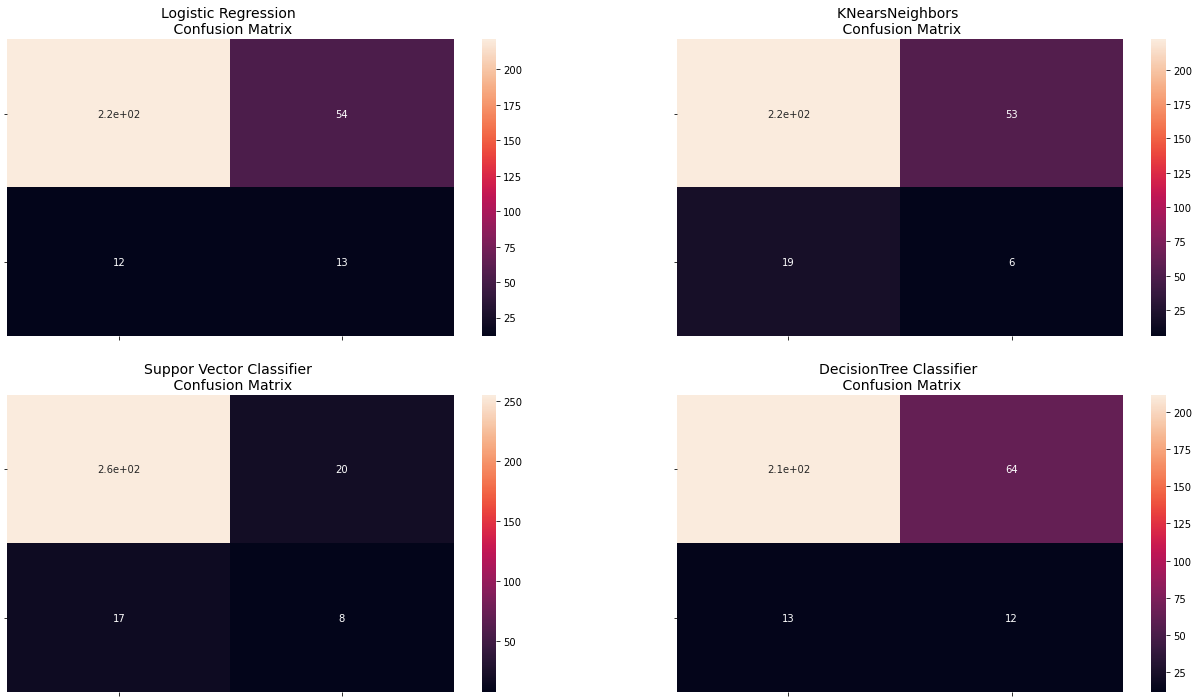

In [168]:
from sklearn.metrics import confusion_matrix

# fitted using SMOTE technique
y_pred_log_reg = best_lrgr.predict(X_test)
y_pred_knear = best_knears.predict(X_test)
y_pred_svc = best_svc.predict(X_test)
y_pred_tree = best_tree.predict(X_test)


log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)


fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

#### Logistic Regression

0.7549129702414374


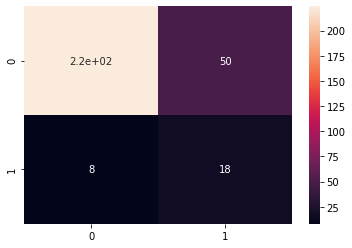

In [432]:
y_pred = best_lrgr.predict(orgXtest)
score = balanced_accuracy_score(orgytest, y_pred)

confu = confusion_matrix(orgytest, y_pred)

print(score)
sns.heatmap(confu, annot=True)

### Manual parameter tuning

#### Random Forrest Classifier

0.7850926445816957


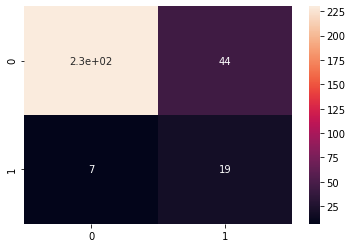

In [381]:
y_pred = best_forrest.predict(orgXtest)
score = balanced_accuracy_score(orgytest, y_pred)

confu = confusion_matrix(orgytest, y_pred)

print(score)
sns.heatmap(confu, annot=True)

#### k-Nearest Neighbors

0.8874227961819203


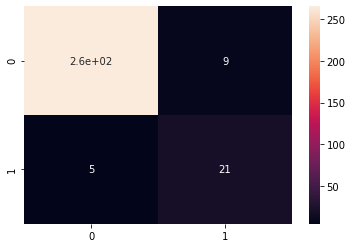

In [408]:
y_pred = best_knn.predict(orgXtest)
score = balanced_accuracy_score(orgytest, y_pred)

confu = confusion_matrix(orgytest, y_pred)

print(score)
sns.heatmap(confu, annot=True)

#### Logistic Regression

0.7704941044357103


<AxesSubplot:>

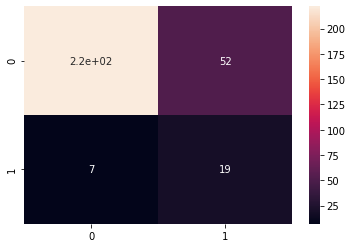

In [431]:
y_pred = best_lr.predict(orgXtest)
score = balanced_accuracy_score(orgytest, y_pred)

confu = confusion_matrix(orgytest, y_pred)

print(score)
sns.heatmap(confu, annot=True)

#### Support Vector Classifier

0.7714766984839978


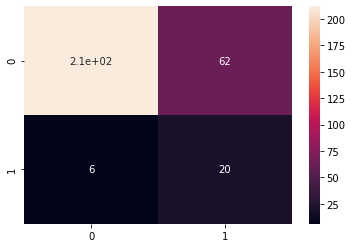

In [423]:
y_pred = best_svm.predict(orgXtest)
score = balanced_accuracy_score(orgytest, y_pred)

confu = confusion_matrix(orgytest, y_pred)

print(score)
sns.heatmap(confu, annot=True)

# Best model

The best model of all was the KNN model with 2 neighbours, obtained by manual tuning. I draw the AUC-ROC curve.

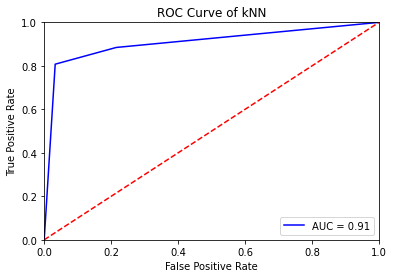

In [433]:
y_scores = best_knn.predict_proba(orgXtest)
fpr, tpr, threshold = roc_curve(orgytest, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()

# Test Data Prediction

At the very end it remains to make a prediction on the test set. Before that, I have to make the same modifications on the test set as I did on the training set.

In [391]:
df_test = pd.read_csv("data/drugs_test.csv")
df_test.drop(columns=['id'], inplace = True)
df_test.head()
df_test.loc[df_test["education"] == "Left school at 17 years", "education"] = "Left school before 18 years"
df_test.loc[df_test["education"] == "Left school at 16 years", "education"] = "Left school before 18 years"
df_test.loc[df_test["education"] == "Left school before 16 years", "education"] = "Left school before 18 years"
df_test.loc[df_test["country"] == "Canada", "country"] = "Other country"
df_test.loc[df_test["country"] == "Ireland", "country"] = "Other country"
df_test.loc[df_test["ethnicity"] == "Asian", "ethnicity"] = "Other"
df_test.loc[df_test["ethnicity"] == "Black", "ethnicity"] = "Other"
df_test.loc[df_test["ethnicity"] == "Other", "ethnicity"] = "Other"
df_test.loc[df_test["ethnicity"] == "White", "ethnicity"] = "Other"
df_test.loc[df_test["ethnicity"] == "Mixed-White/Asian", "ethnicity"] = "Other"
df_test.loc[df_test["ethnicity"] == "Mixed-White/Black", "ethnicity"] = "Other"
df_test.loc[df_test["consumption_alcohol"] == "never used", "consumption_alcohol"] = "more than year ago"
df_test.loc[df_test["consumption_alcohol"] == "used in last decade", "consumption_alcohol"] = "more than year ago"
df_test.loc[df_test["consumption_alcohol"] == "used over a decade ago", "consumption_alcohol"] = "more than year ago"
df_test.loc[df_test["consumption_caffeine"] == "used in last decade", "consumption_caffeine"] = "more than month ago"
df_test.loc[df_test["consumption_caffeine"] == "used over a decade ago", "consumption_caffeine"] = "more than month ago"
df_test.loc[df_test["consumption_caffeine"] == "used in last year", "consumption_caffeine"] = "more than month ago"
df_test.loc[df_test["consumption_caffeine"] == "never used", "consumption_caffeine"] = "more than month ago"
df_test.loc[df_test["consumption_chocolate"] == "used in last decade", "consumption_chocolate"] = "more than month ago"
df_test.loc[df_test["consumption_chocolate"] == "used over a decade ago", "consumption_chocolate"] = "more than month ago"
df_test.loc[df_test["consumption_chocolate"] == "never used", "consumption_chocolate"] = "more than month ago"
df_test.loc[df_test["consumption_chocolate"] == "used in last year", "consumption_chocolate"] = "more than month ago"
df_test.loc[df_test["consumption_mushrooms"] == "used in last week", "consumption_mushrooms"] = "used recently"
df_test.loc[df_test["consumption_mushrooms"] == "used in last day", "consumption_mushrooms"] = "used recently"
df_test = pd.get_dummies(df_test, columns = ['age', 'gender', 'education', 'country', 'ethnicity','consumption_alcohol',
       'consumption_amphetamines', 'consumption_caffeine',
       'consumption_cannabis', 'consumption_chocolate',
       'consumption_mushrooms', 'consumption_nicotine'])
df_test['personality_neuroticism'] = df_test['personality_neuroticism']/100
df_test['personality_extraversion'] = df_test['personality_extraversion']/100
df_test['personality_openness'] = df_test['personality_openness'] / 100
df_test['personality_agreeableness'] = df_test['personality_agreeableness']/100
df_test['personality_conscientiousness'] = df_test['personality_conscientiousness']/100
df_test['personality_impulsiveness'] = df_test['personality_impulsiveness']/100
df_test['personality_sensation'] = df_test['personality_sensation'] /100

,age,gender,education,country,ethnicity,personality_neuroticism,personality_extraversion,personality_openness,personality_agreeableness,personality_conscientiousness,personality_impulsiveness,personality_sensation,consumption_alcohol,consumption_amphetamines,consumption_caffeine,consumption_cannabis,consumption_chocolate,consumption_mushrooms,consumption_nicotine
0,18-24,female,"Some college or university, no certificate or ...",USA,Mixed-Black/Asian,37.7,74.2,60.2,45.6,40.6,63.0,71.1,used in last day,never used,used in last day,used in last week,used in last day,used in last decade,used in last day
1,45-54,male,Doctorate degree,USA,Other,62.3,47.6,73.1,43.5,60.9,56.5,71.1,used in last day,used over a decade ago,used in last day,used in last decade,used in last month,never used,used in last decade
2,45-54,female,Professional certificate/ diploma,USA,Mixed-Black/Asian,56.1,52.6,34.9,58.5,58.4,56.5,38.8,used in last week,never used,used in last day,never used,used in last day,never used,never used
3,35-44,male,"Some college or university, no certificate or ...",Australia,Mixed-Black/Asian,71.8,50.1,45.7,39.0,42.4,63.0,46.6,used in last decade,never used,used in last day,used in last day,used in last week,never used,used in last day
4,35-44,male,Left school at 16 years,USA,Mixed-Black/Asian,62.3,41.2,19.2,39.0,22.3,42.8,38.8,used in last decade,used in last day,used in last day,used in last day,used in last week,used over a decade ago,used in last day


In [399]:
best_knn.predict(df_test)

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,

I save the predictions to a CSV file.

In [401]:
# submission = best_knn.predict(df_test)
# pd.DataFrame(submission).to_csv("classification_SS.csv", header = None, index = None)

# Expected results

Expected value of **`balanced accuracy`: 88%**

---

RESULTS

In [5]:
real = pd.read_csv("real.csv")
obtained = pd.read_csv("classification_SS.csv")

In [12]:
balanced_accuracy_score(real, obtained)

0.6107954545454546

In [13]:
from sklearn.metrics import confusion_matrix

In [14]:
confusion_matrix(real, obtained)

array([[309,  43],
       [ 21,  11]], dtype=int64)